<a href="https://colab.research.google.com/github/matteoturnu/NetSecProject/blob/main/Copia_di_NetSec_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Esercizio Martalò


In [ ]:
!pip install pandas
!pip install numpy

import pandas as pd
import numpy as np

# Import the dataset and create a dataframe
traffic_df = pd.read_csv("Train_Test_Network.csv")
print(traffic_df.columns)

# We need to isolate the fields of interest
clean_df = traffic_df[["proto", "label", "type"]]
print(clean_df)

feature = "type"
analysis_df = clean_df[feature]
print("analysis_df: ", analysis_df)
# counts the unique values for the selected feature and order them
val_count = analysis_df.value_counts().sort_index()
print(val_count)


In [ ]:
# Try to extract some statistics
type_proto_counts = clean_df.groupby('type')['proto'].value_counts().unstack(fill_value=0)
print(type_proto_counts)

NameError: name 'clean_df' is not defined

In [ ]:
# Create categories
category_mapping = {
    'backdoor': 'Malevolent',
    'ddos': 'Malevolent',
    'dos': 'Malevolent',
    'injection': 'Malevolent',
    'mitm': 'Malevolent',
    'normal': 'Benevolent',
    'password': 'Malevolent',
    'ransomware': 'Malevolent',
    'scanning': 'Malevolent',
    'xss': 'Malevolent',
}

# Use .loc to modify the original DataFrame
clean_df.loc[:, 'type'] = clean_df['type'].replace(category_mapping)

In [ ]:
subset_size = 1000
# shuffle the dataframe and make the index start from 0 again
clean_df = clean_df.sample(frac=1).reset_index(drop=True)
print(clean_df)


In [ ]:
# divide dataframe into subsets of 1000 samples
subsets = [clean_df.iloc[i:i+subset_size] for i in range(0, len(clean_df), subset_size)]
print(subsets[0])

subset_numbers = []
percent_tcp_normal = []
percent_tcp_malevolent = []

# Calculate the percentage of TCP in "proto" for each class in each subnet
for i, subset in enumerate(subsets, start=1):
    # count the number of benevolent packets for the current subset
    total_obs_ben = subset[subset['type'] == 'Benevolent']['type'].value_counts(normalize=False)
    #print("\nSubset ", i)
    #print(total_obs_ben)
    total_obs_ben = total_obs_ben.get('Benevolent', 0)
    #print(total_obs_ben)
    #print(tcp_counts)

    total_obs_mal = subset[subset['type'] == 'Malevolent']['type'].value_counts(normalize=False)
    #print("\nSubset ", i)
    #print(total_obs_ben)
    total_obs_mal = total_obs_mal.get('Malevolent', 0)
    #print(total_obs_ben)

    # count the number of TCP benevolent packets for current subset
    tcp_counts = subset[subset["proto"] == 'tcp']['type'].value_counts(normalize=False)

    # Append the results to the lists
    subset_numbers.append(i)
    if total_obs_ben != 0:
        percent_tcp_normal.append(tcp_counts.get('Benevolent', 0) * 100 / total_obs_ben)
    else:
        percent_tcp_normal.append(0)
    print(f"Percentage: {percent_tcp_normal}")

    if total_obs_mal != 0:
        percent_tcp_malevolent.append(tcp_counts.get('Malevolent', 0) * 100 / total_obs_mal)
    else:
        percent_tcp_malevolent.append(0)

## Dataset e p-value

In [ ]:
import pandas as pd

url = 'https://raw.githubusercontent.com/matteoturnu/NetSecProject/refs/heads/main/BenignAndMaliciousDataset.csv'
traffic_df = pd.read_csv(url)

print(traffic_df.shape)


(90000, 34)


In [ ]:
from scipy import stats

new_numeric_dataset = traffic_df.select_dtypes(include=['number','boolean'])
# we removed domain because they are based on incremental IDs
new_numeric_dataset = new_numeric_dataset.drop(columns=['Domain'])

# Supponiamo che la colonna 'target' contenga 0 per traffico benevolo e 1 per traffico malevolo
target = 'Class'
feature_columns = [col for col in new_numeric_dataset.columns if col != target]

# Test ANOVA per ciascuna feature numerica
p_values = {}  # Dizionario per salvare i p-values
for feature in feature_columns:
    # Dividi i dati in due gruppi (malevolo e benevolo)
    group_benign = new_numeric_dataset[new_numeric_dataset[target] == 0][feature]
    group_malicious = new_numeric_dataset[new_numeric_dataset[target] == 1][feature]
    # Applica ANOVA
    stat, p_value = stats.f_oneway(group_benign, group_malicious)
    # Salva il p-value per ogni feature
    p_values[feature] = p_value
    # Verifica il risultato
    print(f'Feature: {feature}, P-value: {p_value}')
    if p_value < 0.01:  # Soglia di significatività 0.05
        print(f'La feature {feature} è significativa.')
    else:
        print(f'La feature {feature} NON è significativa.')

Feature: MXDnsResponse, P-value: 0.0
La feature MXDnsResponse è significativa.
Feature: TXTDnsResponse, P-value: 0.0
La feature TXTDnsResponse è significativa.
Feature: HasSPFInfo, P-value: 0.0
La feature HasSPFInfo è significativa.
Feature: HasDkimInfo, P-value: 0.0006456116132352973
La feature HasDkimInfo è significativa.
Feature: HasDmarcInfo, P-value: 1.3907683401786138e-62
La feature HasDmarcInfo è significativa.
Feature: Ip, P-value: 3.4211602974075064e-34
La feature Ip è significativa.
Feature: DomainInAlexaDB, P-value: 3.065702243016074e-94
La feature DomainInAlexaDB è significativa.
Feature: CommonPorts, P-value: 0.0
La feature CommonPorts è significativa.
Feature: CreationDate, P-value: 0.0
La feature CreationDate è significativa.
Feature: LastUpdateDate, P-value: 0.0
La feature LastUpdateDate è significativa.
Feature: ASN, P-value: 5.493047646465009e-109
La feature ASN è significativa.
Feature: HttpResponseCode, P-value: 0.0
La feature HttpResponseCode è significativa.
Featu

##Correlazione feature

<Axes: >

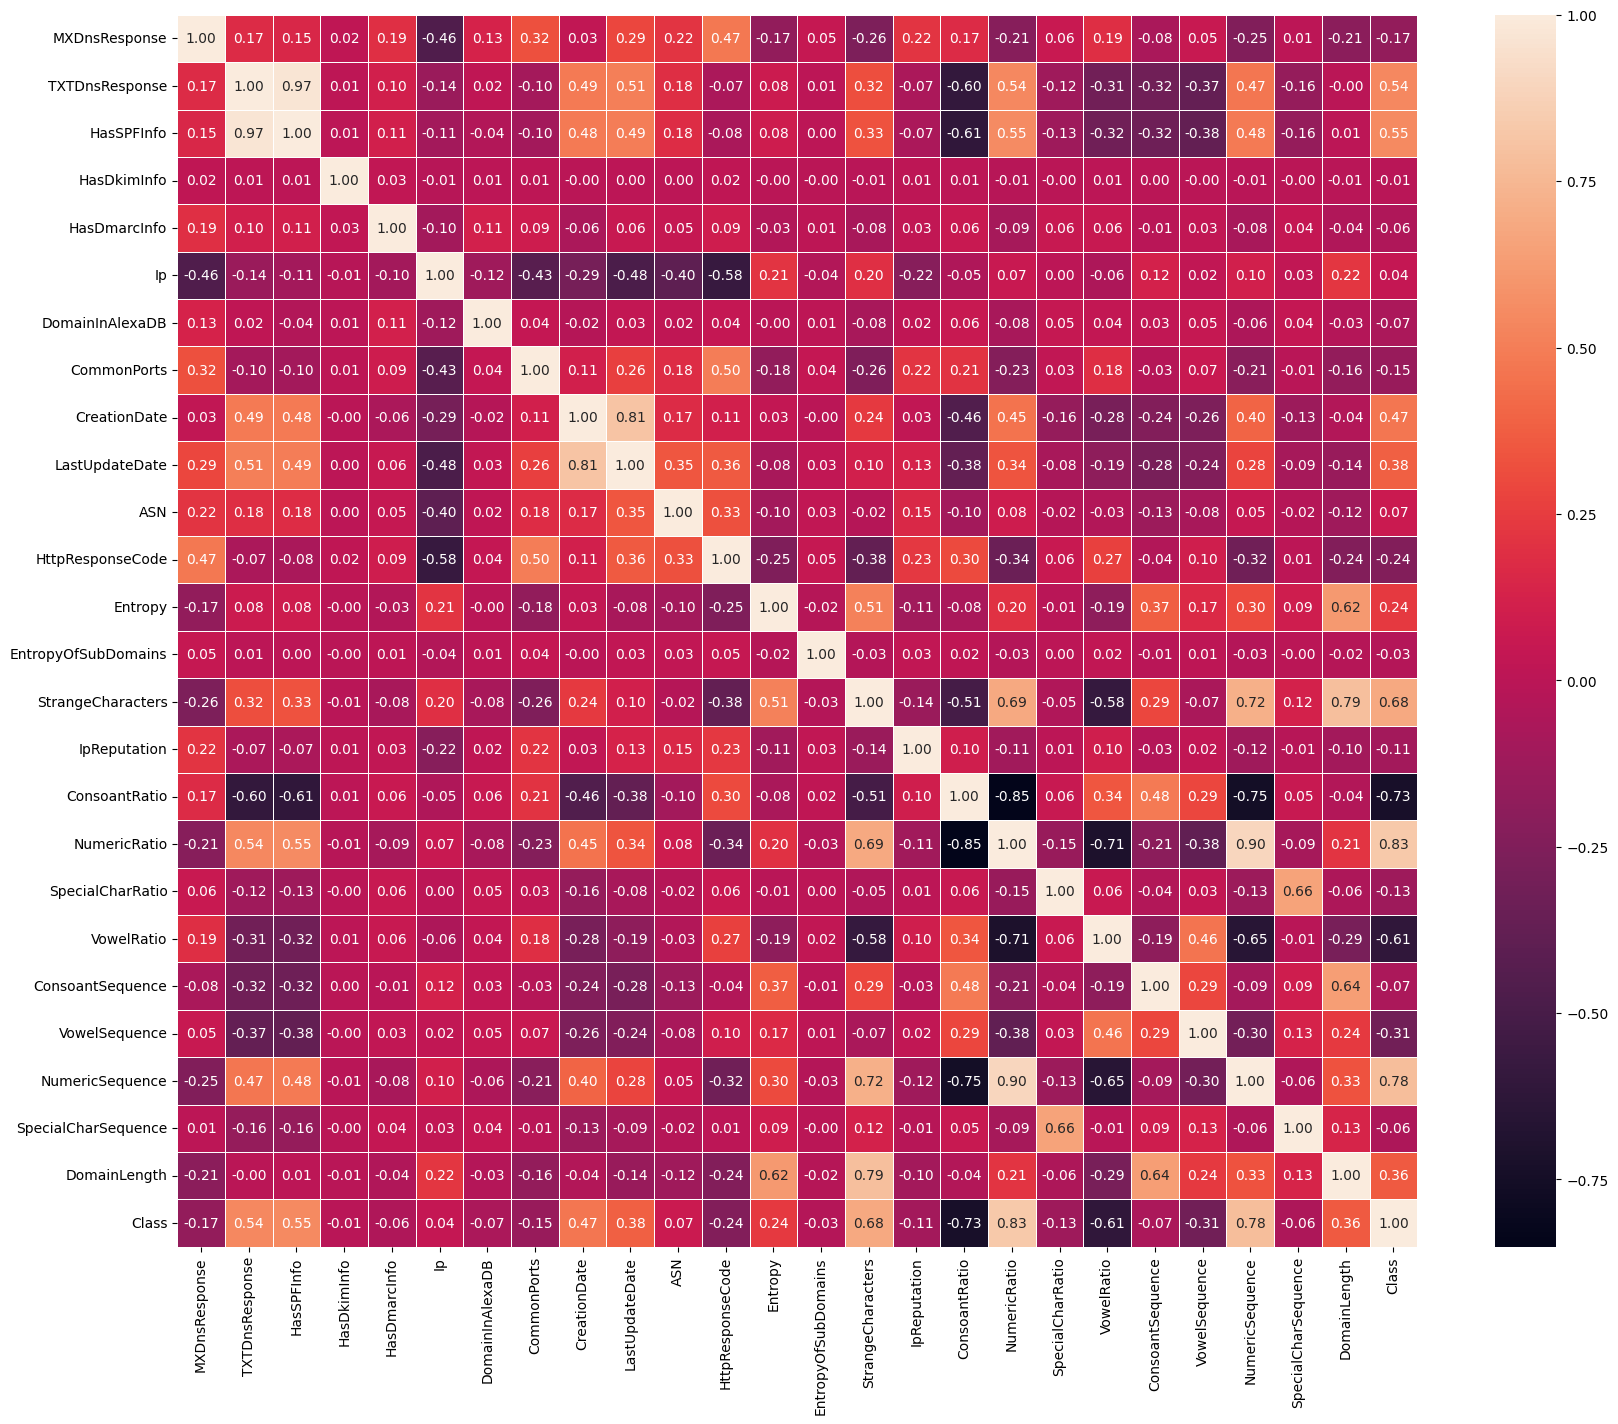

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# previous test shows these features are not important for determining the class
new_numeric_dataset = new_numeric_dataset.drop(columns=['DomainReputation', 'SubdomainNumber'])

corr_matrix = new_numeric_dataset.corr()
plt.figure(figsize=(20, 16))
sns.heatmap(corr_matrix, annot=True, linewidth=0.5, fmt='.2f')

## Chosen features (based on high correlation with the class)
- TXTDnsResponse
- HasSPFInfo
- StrangeCharacters
- ConsonantRatio
- Numeric ratio
- VowelRatio
- NumericSequence

<Axes: >

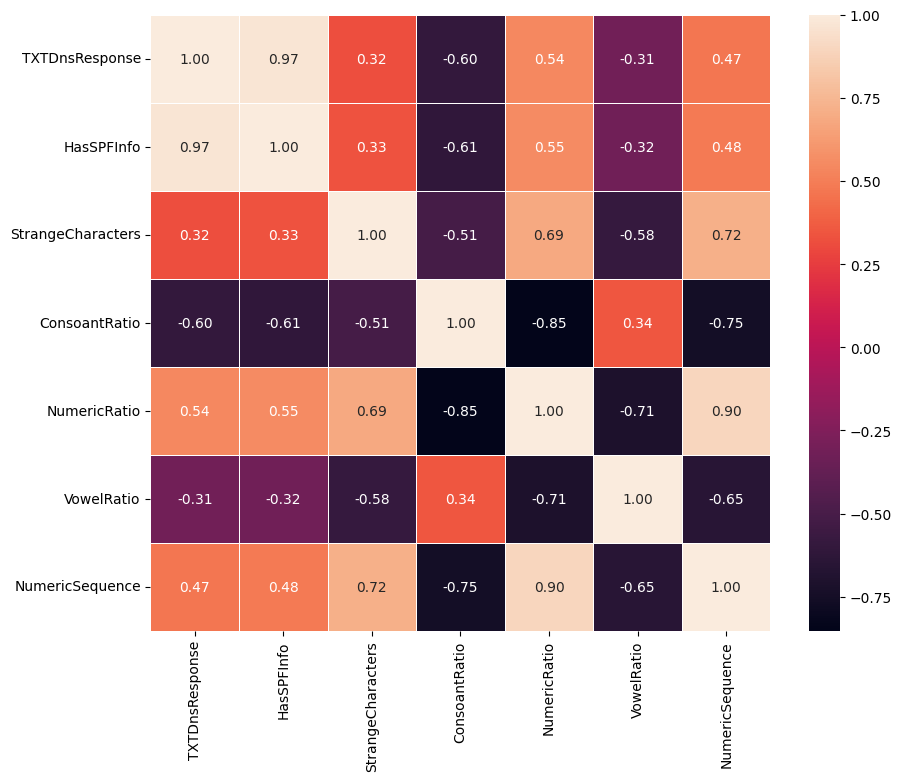

In [ ]:
features = ['TXTDnsResponse', 'HasSPFInfo', 'StrangeCharacters', 'ConsoantRatio', 'NumericRatio', 'VowelRatio', 'NumericSequence']
new_numeric_dataset = new_numeric_dataset[features]

corr_matrix = new_numeric_dataset.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, linewidth=0.5, fmt='.2f')

Now, looking at correlation between features themselves:
- choosing consonantRatio against NumericRatio
- keeping TXTDnsResponse against HasSPFInfo
- choosing NumericSequence against consonantRatio (4 features left)

Left: NumericSequence, TXTDnsResponse, StrangeCharacters, VowelRatio (next test: maybe remove NumericSequence or VowelRatio)

In [ ]:
# Test to evaluate how much the samples distribution is a Gaussian one

from scipy import stats

# Esempio di dati


# Esegui il test di Shapiro-Wilk
stat, p_value = stats.shapiro(X)

#stat, p_value = stats.shapiro(new_numeric_dataset)

print('Statistic:', stat)
print('p-value:', p_value)

if p_value > 0.05:
    print('Distribuzione probabilmente normale (non rifiuto H0)')
else:
    print('Distribuzione non normale (rifiuto H0)')

NameError: name 'X' is not defined

In [ ]:
"""plt.hist(X, bins=30, density=True)
plt.show()

plt.hist(X['StrangeCharacters'], bins=30, density=True)  # Plot normalized histogram
plt.show()

plt.hist(X['VowelRatio'], bins=30, density=True)  # Plot normalized histogram
plt.show()

plt.hist(X['NumericSequence'], bins=30, density=True)  # Plot normalized histogram
plt.show()"""

"plt.hist(X, bins=30, density=True)\nplt.show()\n\nplt.hist(X['StrangeCharacters'], bins=30, density=True)  # Plot normalized histogram\nplt.show()\n\nplt.hist(X['VowelRatio'], bins=30, density=True)  # Plot normalized histogram\nplt.show()\n\nplt.hist(X['NumericSequence'], bins=30, density=True)  # Plot normalized histogram\nplt.show()"

In [ ]:
import pandas as pd
#pd.DataFrame(X).hist(figsize=(12, 8))

final_features = ['TXTDnsResponse', 'StrangeCharacters', 'VowelRatio', 'NumericSequence']

# sort of probability distribution for each feature
# they are NO gaussian ones


hist, bins = np.histogram(X['StrangeCharacters'], bins=30, density=True)  # Create histogram and normalize
plt.hist(X['StrangeCharacters'], bins=30, density=True)  # Plot normalized histogram
plt.show()

hist, bins = np.histogram(X['VowelRatio'], bins=30, density=True)  # Create histogram and normalize
plt.hist(X['VowelRatio'], bins=30, density=True)  # Plot normalized histogram
plt.show()

hist, bins = np.histogram(X['NumericSequence'], bins=30, density=True)  # Create histogram and normalize
plt.hist(X['NumericSequence'], bins=30, density=True)  # Plot normalized histogram
plt.show()

NameError: name 'np' is not defined

##Addestramento KNN

In [ ]:
final_features = ['TXTDnsResponse', 'StrangeCharacters', 'VowelRatio', 'NumericSequence']

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report

for feature in new_numeric_dataset:
    print(f"\nAnalizzando la feature: {feature}")

    X = traffic_df[features]
    y = traffic_df['Class']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    k = 5
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)

    y_pred = knn.predict(X_test)

    print(f'Accuracy: {accuracy_score(y_test, y_pred):.2f}')
    print('Classification Report:')
    print(classification_report(y_test, y_pred))

    for k in range(1, 5):
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_test)
        print(f'k={k}, Accuracy: {accuracy_score(y_test, y_pred):.2f}')


Analizzando la feature: MXDnsResponse
Accuracy: 0.96
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.95      0.96     13378
           1       0.96      0.97      0.97     13622

    accuracy                           0.96     27000
   macro avg       0.96      0.96      0.96     27000
weighted avg       0.96      0.96      0.96     27000

k=1, Accuracy: 0.96
k=2, Accuracy: 0.96
k=3, Accuracy: 0.96
k=4, Accuracy: 0.96

Analizzando la feature: TXTDnsResponse
Accuracy: 0.96
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.95      0.96     13378
           1       0.96      0.97      0.97     13622

    accuracy                           0.96     27000
   macro avg       0.96      0.96      0.96     27000
weighted avg       0.96      0.96      0.96     27000

k=1, Accuracy: 0.96
k=2, Accuracy: 0.96
k=3, Accuracy: 0.96
k=4, Accuracy: 0.96

Analizzando la feature: HasSPF

KeyboardInterrupt: 

In [ ]:
final_features = ['TXTDnsResponse', 'StrangeCharacters', 'VowelRatio', 'NumericSequence']

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report


X = traffic_df[final_features]
y = traffic_df['Class']

# Split dataset into 70% training and 30% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Feature normalization for KNN
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Fit the model
k = 5
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train, y_train)


# Model evaluation
y_pred = knn.predict(X_test)

print(f'Accuracy: {accuracy_score(y_test, y_pred):.2f}')
print('Classification Report:')
print(classification_report(y_test, y_pred))

# Test on accuracy for different values of k
for k in range(1, 11):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    print(f'k={k}, Accuracy: {accuracy_score(y_test, y_pred):.2f}')


Accuracy: 0.96
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.94      0.96     13378
           1       0.94      0.97      0.96     13622

    accuracy                           0.96     27000
   macro avg       0.96      0.96      0.96     27000
weighted avg       0.96      0.96      0.96     27000

k=1, Accuracy: 0.93
k=2, Accuracy: 0.93
k=3, Accuracy: 0.95
k=4, Accuracy: 0.94
k=5, Accuracy: 0.96
k=6, Accuracy: 0.95
k=7, Accuracy: 0.96
k=8, Accuracy: 0.95
k=9, Accuracy: 0.96
k=10, Accuracy: 0.95


##Grafici

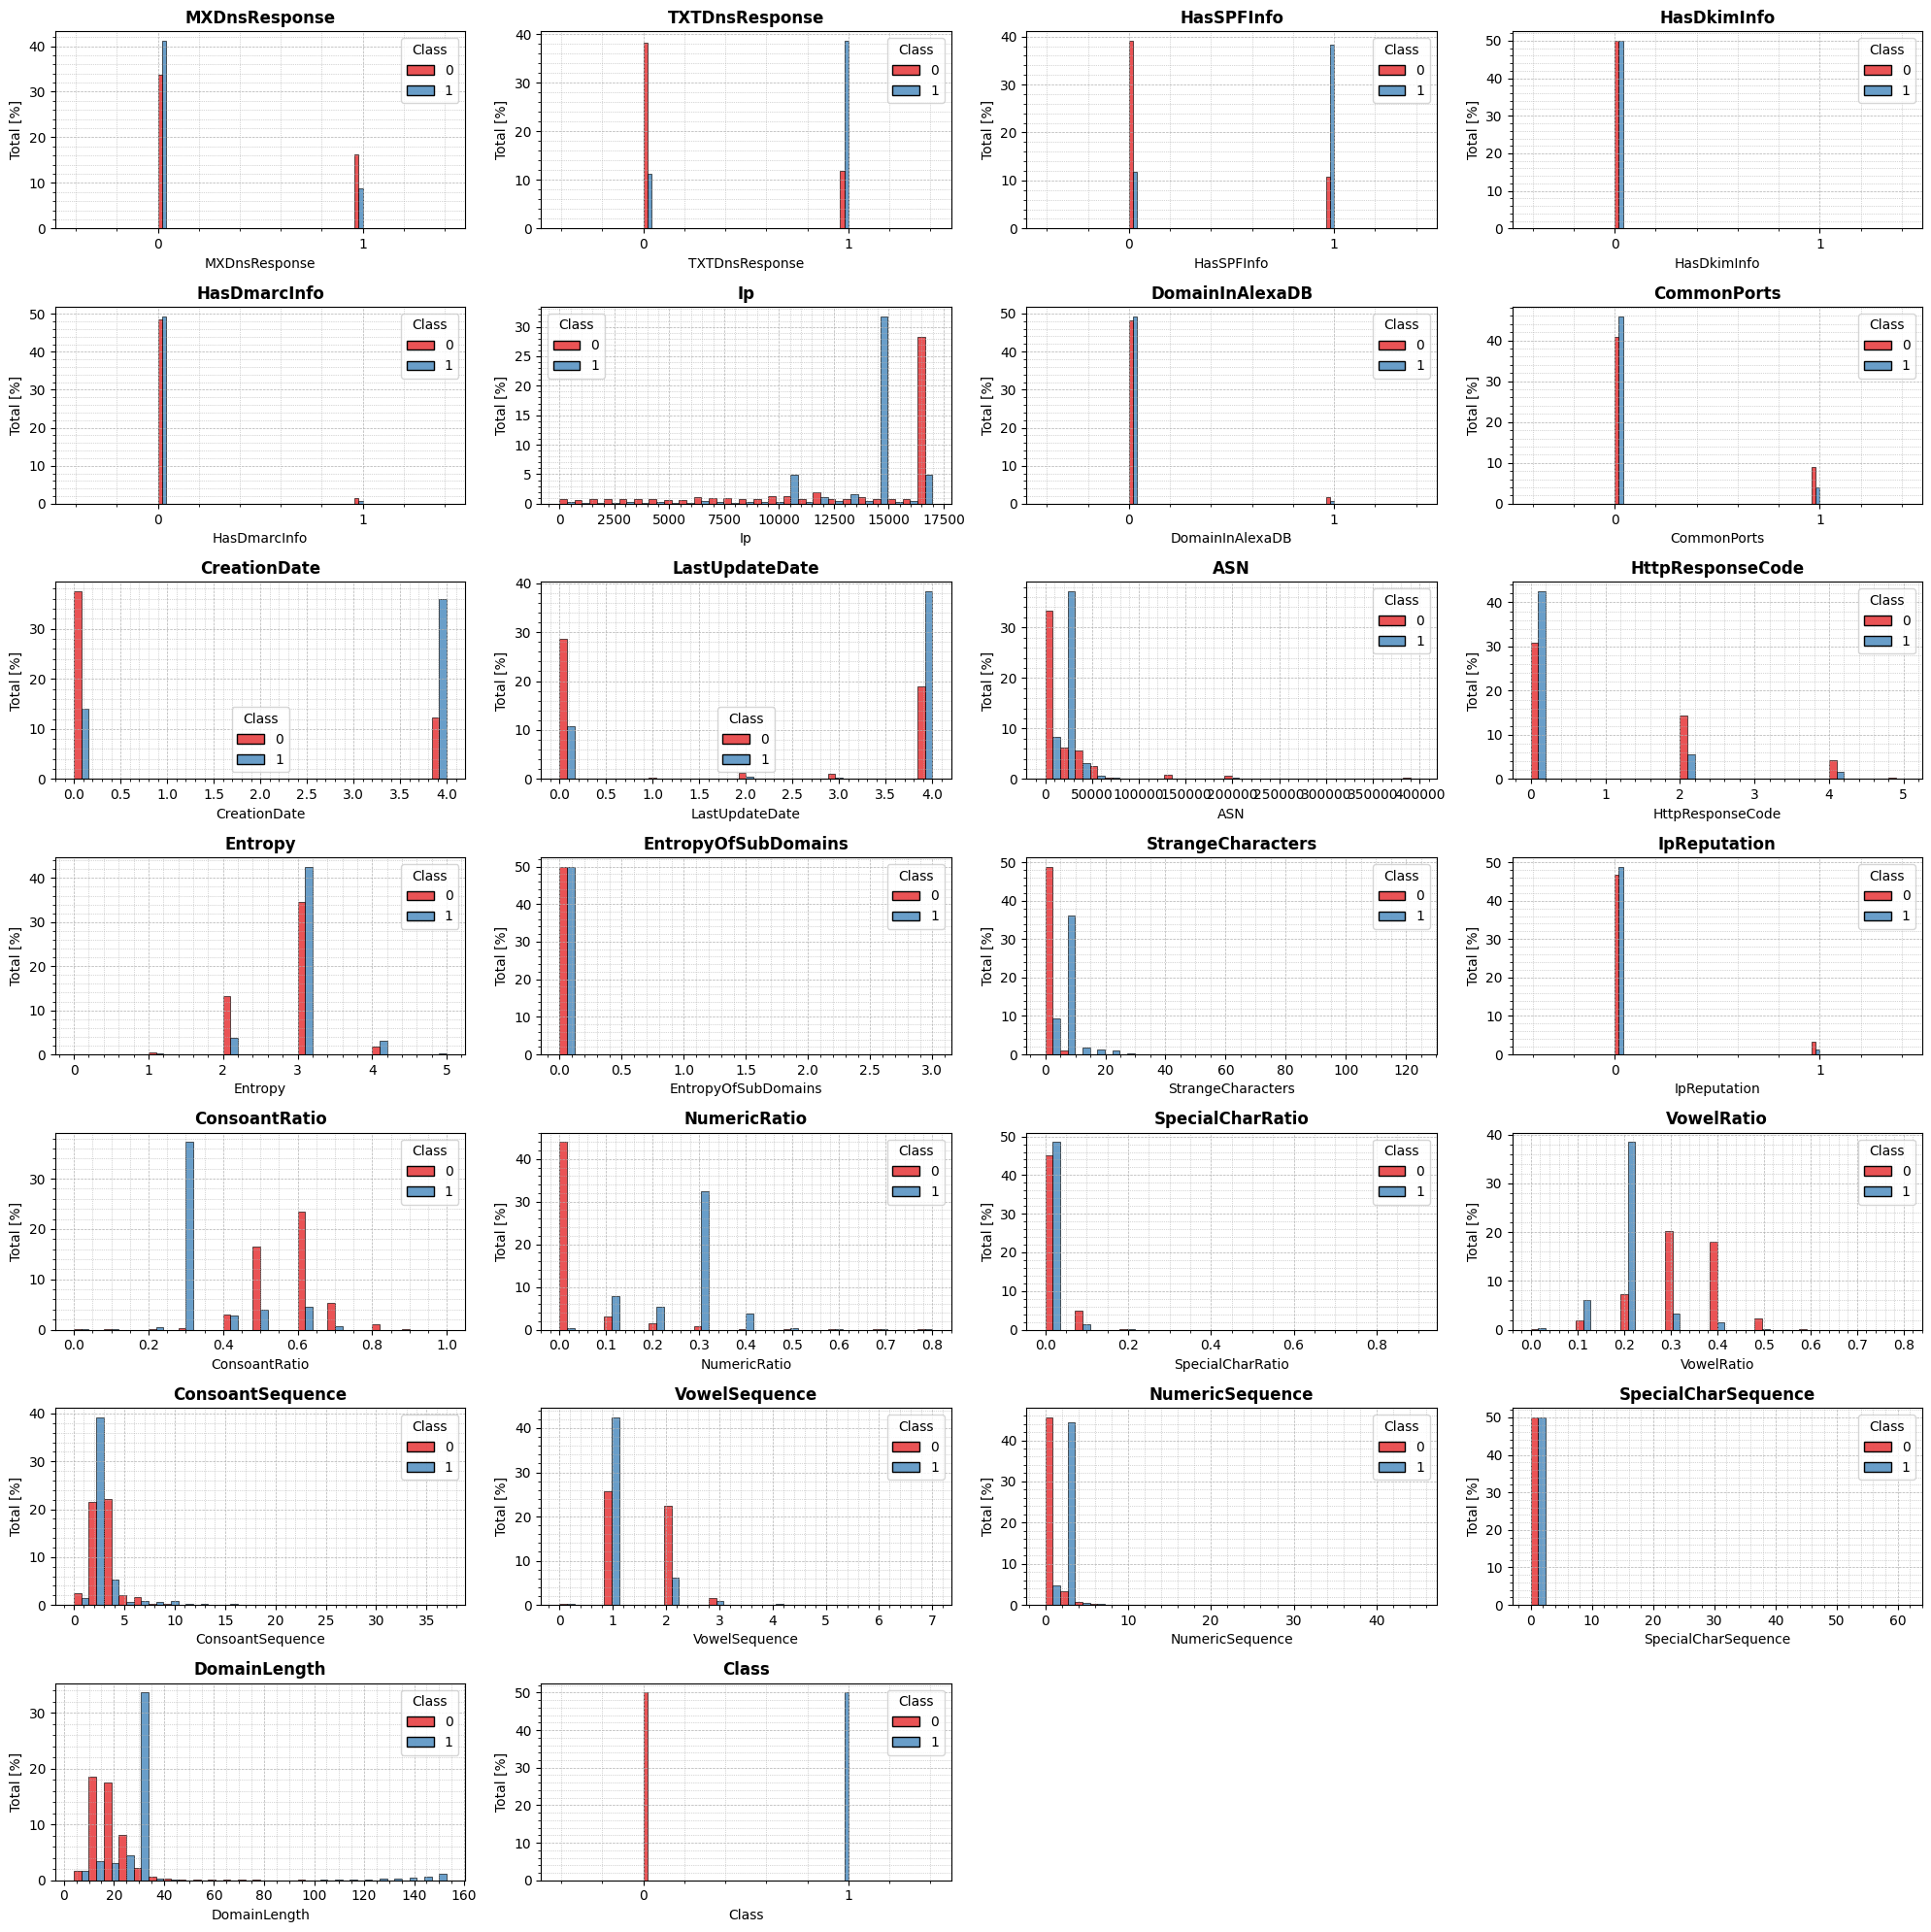

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Crea una figura con sottotrame per ciascuna feature
plt.figure(figsize=(20, 20))

# Cicla attraverso le feature finali
for i, feature in enumerate(new_numeric_dataset, 1):
    plt.subplot(7, 4, i)
    plot = sns.histplot(data=traffic_df, x=feature, hue='Class', multiple='dodge', palette='Set1', bins=25, stat='percent')

    if traffic_df[feature].nunique() == 2:  # Controlla se la feature ha solo 2 valori (booleano)
        plt.xticks([0, 1])
        plt.xlim(-0.5, 1.5)

    plt.title(f'{feature}', fontweight='bold')
    plt.ylabel('Total [%]')

    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.minorticks_on()
    plt.grid(True, which='minor', linestyle=':', linewidth=0.5)

# Mostra la figura
plt.tight_layout()
plt.show()